# Exploring the use of sparse matrices for storing water depth 
(because most of the depths are zeros)


In [23]:
%load_ext autoreload
%autoreload 2 
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from typing import Optional, Tuple
from tqdm.autonotebook import tqdm
import sparse
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Below is an example of how to create a sparse matrix using the `spare` library from https://ncar.github.io/esds/posts/2022/sparse-PFT-gridding/#introduction-to-sparse-arrays

In [3]:
array = sparse.COO(
    coords=[[0, 1, 2], [0, 1, 2]],
    data=np.array([1, 1, 1], dtype=np.float32),
    shape=(4, 4),
    fill_value=np.nan,
)
array


Format,coo
Data Type,float32
Shape,"(4, 4)"
nnz,3
Density,0.1875
Read-only,True
Size,60
Storage ratio,0.94


Load some results from running fsm_xarray with gridSearch, which was generated and saved using /Users/jkingslake/Documents/science/meltwater_routing/BFRN_meltwater/python/notebooks/usingGridSearch.ipynb

In [62]:
results = xr.open_dataset('results_small_test3.nc')


A simpler way to generate sparse matrices is to use the .from_numpy method:

In [63]:
sparse_water_depth = sparse.COO.from_numpy(results['water_depth'].values)

In [64]:
sparse_water_depth

Format,coo
Data Type,float64
Shape,"(3072, 1024, 2, 2)"
nnz,43554
Density,0.0034613609313964844
Read-only,True
Size,1.7M
Storage ratio,0.02


This sparse matrix can be slotted in to the results xarray.Dataset as a replacement for the 'dense' array it derived form. 

In [65]:
results['water_depth'].values = sparse_water_depth

Plotting works the same as usual. 

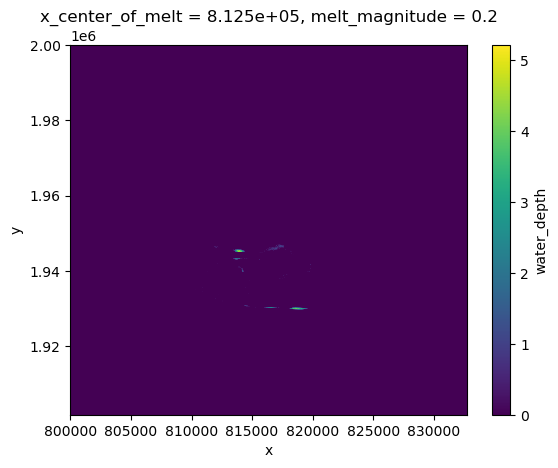

In [66]:
results['water_depth'].isel(melt_magnitude=0, x_center_of_melt=0).plot()

To get the dense array back, use the .as_numpy() method.

In [67]:
results['water_depth'].as_numpy()

<xarray.DataArray 'water_depth' (y: 3072, x: 1024, x_center_of_melt: 2,
                                 melt_magnitude: 2)>
array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],

...

       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]])
Coordinates:
  * x_center_of_melt  (x_center_of_melt) float64 8.125e+05 8.175e+05
  * melt_magnitude    (melt_magnitude) float64 0.2 2.0
  * x                 (x) float64 8e+05 8e+05 8.001e+05 ... 8.327e+05 8.327e+05
  * y                 (y) float64 2e+06 2e+06 2e+06 ... 1.902e+06 1.902e+06
Attributes:
    AREA_OR_POINT:       Area
    PROCESSING_HISTORY:  2024-02-19 19:51:18 UTC | RichDEM v2.2.9 (hash=41503...
    TIFFTAG_DATETIME:    2024-02-19 19:51:18 UTC
    TIFFTAG_SOFTWARE:    RichDEM v2.2.9 (hash=415032db2f303721, compiled=2024...
    grid_mapping:        spatial_ref

Finally, make a function that does this replacement-with-a-sparse-version for any dataset and any variable in the dataset. This will be added to func.py.

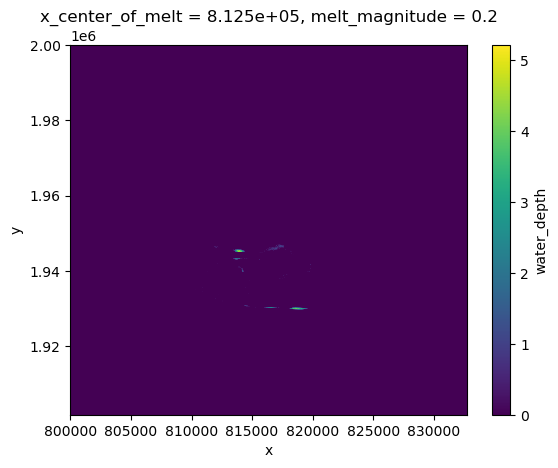

In [68]:
def replace_dense_with_sparse(results, variable):
    sparse_variable = sparse.COO.from_numpy(results[variable].values)
    results[variable].values = sparse_variable
    return results

results = xr.open_dataset('results_small_test.nc')

results = replace_dense_with_sparse(results, 'water_depth')
results.water_depth.isel(melt_magnitude=0, x_center_of_melt=0).plot()

Access information on this data using `.data`

In [69]:
results.water_depth.data

Format,coo
Data Type,float64
Shape,"(3072, 1024, 2, 2)"
nnz,43554
Density,0.0034613609313964844
Read-only,True
Size,1.7M
Storage ratio,0.02


and, for example,

In [70]:
results.water_depth.data.density

0.0034613609313964844

In [71]:
results = replace_dense_with_sparse(results, 'melt')
results.melt

Format,coo
Data Type,float32
Shape,"(3072, 1024, 2, 2)"
nnz,97344
Density,0.0077362060546875
Read-only,True
Size,3.3M
Storage ratio,0.07


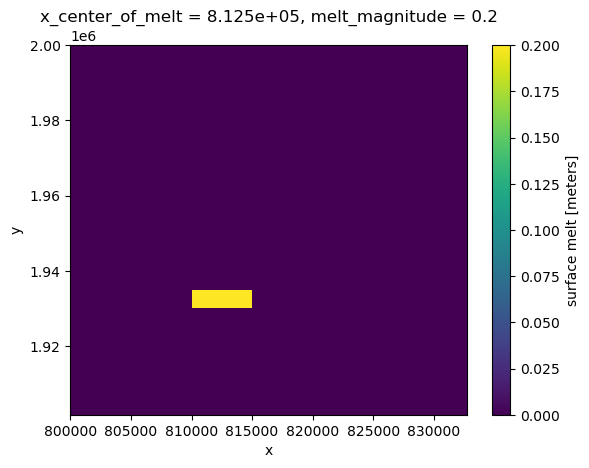

In [72]:
results.melt.isel(melt_magnitude=0, x_center_of_melt=0).plot()


## Test the implementation in func.py

In [73]:
sys.path.append("..") 
import scripts.funcs as fun

In [74]:
results_dense = fun.gridSearch(fun.fsm_xarray, x_center_of_melt = [812500.0], melt_magnitude=[0.2], sparse=False)
results_dense.water_depth

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.DataArray 'water_depth' (y: 3072, x: 1024, x_center_of_melt: 1,
                                 melt_magnitude: 1, sparse: 1)>
array([[[[[0.]]],


        [[[0.]]],


        [[[0.]]],


        ...,


        [[[0.]]],


        [[[0.]]],


        [[[0.]]]],

...

       [[[[0.]]],


        [[[0.]]],


        [[[0.]]],


        ...,


        [[[0.]]],


        [[[0.]]],


        [[[0.]]]]])
Coordinates:
  * x_center_of_melt  (x_center_of_melt) float64 8.125e+05
  * melt_magnitude    (melt_magnitude) float64 0.2
  * sparse            (sparse) bool False
  * x                 (x) float64 8e+05 8e+05 8.001e+05 ... 8.327e+05 8.327e+05
  * y                 (y) float64 2e+06 2e+06 2e+06 ... 1.902e+06 1.902e+06
    spatial_ref       int64 0
Attributes:
    AREA_OR_POINT:       Area
    PROCESSING_HISTORY:  2024-02-19 20:08:06 UTC | RichDEM v2.2.9 (hash=41503...
    TIFFTAG_DATETIME:    2024-02-19 20:08:06 UTC
    TIFFTAG_SOFTWARE:    RichDEM v2.2.9 (hash=415032db2f303721, compiled=2024...
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

In [75]:
results_sparse = fun.gridSearch(fun.fsm_xarray, x_center_of_melt = [812500.0], melt_magnitude=[0.2])
results_sparse.water_depth

  0%|          | 0/1 [00:00<?, ?it/s]

Format,coo
Data Type,float64
Shape,"(3072, 1024, 1, 1)"
nnz,5369
Density,0.0017067591349283855
Read-only,True
Size,209.7K
Storage ratio,0.01


In [76]:
(results_sparse.melt.as_numpy().data == results_dense.melt.isel(sparse=0).load().data).all()

True